In [5]:
import matplotlib.pyplot as plt
import numpy as np
from price_process.process import *

# MonteCarlo pricing of European options

## Standard geometric process

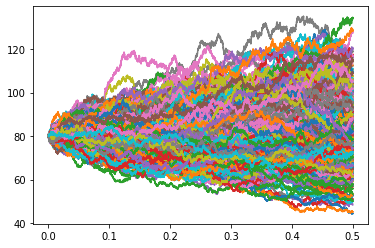

In [6]:
# parameters
strike = 75
init_price = 80
time_to_maturity = 1/2
vol = 0.25
r = 0.05 # risk free rate
q = 0.01 # cont. yield div rate
price_proc = Gaussian([10000, 1000], T=time_to_maturity).to_geometric(r-q, vol)
plt.figure()
plt.hist(price_proc.returns(), 80, density=True, histtype='step');
plt.figure()
plt.plot(price_proc.t, price_proc.process[:, :400]*init_price);

In [7]:
call_price = np.exp(-r*time_to_maturity)*np.sum(np.maximum(price_proc.process[-1, :]*init_price - strike, 0)) / price_proc.process.shape[1]
print(f"Call price: {round(call_price, 3)}")

Call price: 9.036


This approximately matches the B-S price for the same call option:

In [8]:
def bs_call(x, k, ttm, r, q, sigma):
    d1 = (np.log(x/k) + (r-q + sigma**2/2)*ttm) / (sigma*np.sqrt(ttm))
    d2 = d1 - sigma*np.sqrt(ttm)
    return x*np.exp(-q*ttm)* norm.cdf(d1) - k*np.exp(-r*ttm)*norm.cdf(d2)

bs_call(init_price, strike, time_to_maturity, r, q, vol)

9.207219425035397

## Levy process

/opt/python/envs/default/lib/python3.8/site-packages/price_process/process.py:55: RuntimeWarning: overflow encountered in exp
  self.process = normalize(np.exp(self.log_process*vol*np.sqrt(self.dt)+self.dt*(drift-0.5*vol**2)),0)


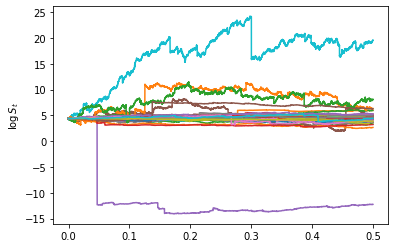

In [9]:
price_proc = Levy(1.6, 0.7, [10000, 1000], T=time_to_maturity).to_geometric(r-q, vol)
plt.figure()
plt.hist(price_proc.returns(), 80, density=True, histtype='step', range=[-0.05, 0.05]);
plt.figure()
plt.plot(price_proc.t, np.log(price_proc.process[:, :50]*init_price))
plt.ylabel(r"$\log S_t$");

Clearly there is a problem with enormous price moves that are not going to actually be realized. We can impose a hard price-move cutoff on our valid paths so that we count only *tame* jump price processes. The cutoff would then be estimated by fitting empirical option prices.

In [12]:
gamma = 3
call_price_ = []
filtered_paths = []
for i in range(len (price_proc.process[0, :])):
    max_move = np.abs((price_proc.process[:, i]*init_price).max()-(price_proc.process[:, i]*init_price).min())
    if max_move < gamma*vol*init_price:
        call_price_.append(np.exp(-r*time_to_maturity)*(np.maximum(price_proc.process[-1, i]*init_price - strike, 0))) 
        filtered_paths.append(price_proc.process[:, i]*init_price)
print(f"Call price: {round(np.mean(call_price_), 3)}")


Call price: 8.785


<ipython-input-12-194812f397b8>:5: RuntimeWarning: overflow encountered in multiply
  max_move = np.abs((price_proc.process[:, i]*init_price).max()-(price_proc.process[:, i]*init_price).min())


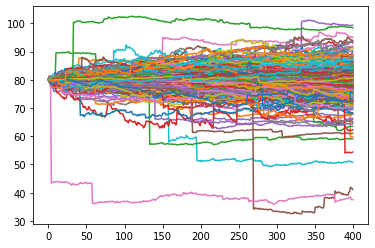

In [13]:
plt.plot(np.array(filtered_paths).T[:400]);

The cutoff chosen here is $\gamma=3$ which allows for maximum price swings rougly in the order of the initial price. I've also chosen parameters to really showcase the jumps. 